In [69]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import periodogram
import pandas as pd
import csv
from physoce import tseries as ts
%matplotlib notebook

In [70]:
# load files .dat and .sen from whatever day 
file = 'SWCAD402.dat'
file2 = 'SWCAD402.sen'

In [71]:
# Combine the two files 
df = pd.read_csv(file, sep =  '\s+', names=["Burst_counter", "Ensemble_counter", "Velocity_East(m/s)", "Velocity_North(m/s)", 
"Velocity_Up(m/s)","Amplitude(Beam1)","Amplitude(Beam2) ","Amplitude(Beam3) ","SNR(Beam1)", "SNR(Beam2)","SNR(Beam3)","Correlation(Beam1)",
"Correlation(Beam2) ", "Correlation(Beam3) ", "Pressure","Analog_input_1","Analog_input_2", "Checksum"])
df2 = pd.read_csv(file2, sep= '\s+', names=["Month", "Day", "Year", "Hour", "Minute", "Second", "Error", "Status", "volt", "SoundSpeed", "Heading", "Pitch", "Roll", "Temp", "Input", "Checksum"])
df3 = pd.concat([df, df2], axis=1) # Combine the two files

In [72]:
# Save combined file .csv
df3.to_csv('combined.csv')


In [73]:
Start_Time, End_Time =(1446,1506) # input start and end time (military) ex: 10:45am - 1:05pm = 1045,1305

In [74]:
df3['Time']= (df3['Hour']*100)+ (df3['Minute']) #make new time column for indexing time in military style 

runindex = (df3['Time']>Start_Time-1) & (df3['Time']<End_Time+1) # index by start and end time
#convert pressure to depth (m). Equeation from Seabird http://www.seabird.com/document/an69-conversion-pressure-depth
Depth = ((((-1.82*10**-15 * df3['Pressure'] + 2.279*10**-10)* df3['Pressure'] - 2.2512*10**-5 ) * df3['Pressure'] + 9.72659) * df3['Pressure']) /9.80665




In [75]:
#define all variables of interest 
Mean_VN = np.mean(df3['Velocity_North(m/s)'][runindex])
Mean_VU = np.mean(df3['Velocity_Up(m/s)'][runindex])
Mean_VE = np.mean(df3['Velocity_East(m/s)'][runindex])
Max_VN = max(df3['Velocity_North(m/s)'][runindex])
Min_VN = min(df3['Velocity_North(m/s)'][runindex])
Max_VE = max(df3['Velocity_East(m/s)'][runindex])
Min_VE = min(df3['Velocity_East(m/s)'][runindex])
Max_VU = max(df3['Velocity_Up(m/s)'][runindex])
Min_VU = min(df3['Velocity_Up(m/s)'][runindex])
SD_VN = np.std(df3['Velocity_North(m/s)'][runindex])
SD_VU = np.std(df3['Velocity_Up(m/s)'][runindex])
SD_VE = np.std(df3['Velocity_East(m/s)'][runindex])
Mean_Depth = np.mean(Depth[runindex])
Max_Depth = max(Depth[runindex])
Min_Depth = min(Depth[runindex])
SD_Depth = np.std(Depth[runindex])
Day= (df2['Day'][1])
Month= (df2['Month'][1])
Year= (df2['Year'][1])




<IPython.core.display.Javascript object>


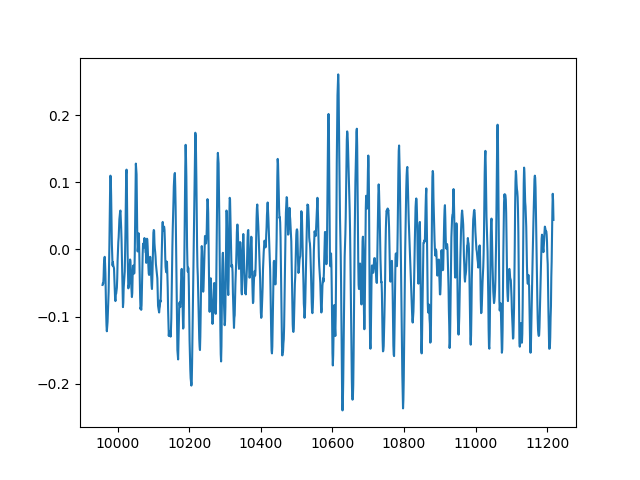

In [76]:
# sanity check if time interval has outliers or bad noise 
plt.figure()
plt.plot(df3['Velocity_East(m/s)'][runindex])

In [77]:
# run PCA for maximum speed in whatever direction saved as U
theta, major, minor=ts.princax(df3['Velocity_East(m/s)'][runindex], df3['Velocity_North(m/s)'][runindex]) #theta = angle, major = SD major axis, SD minor axis 
U, V= ts.rot(df3['Velocity_East(m/s)'][runindex], df3['Velocity_North(m/s)'][runindex], -theta)
# Use standard deviation of speed to git rid of noise and negative values 
SD_U = np.std(U)
SD_V = np.std(V)

<IPython.core.display.Javascript object>


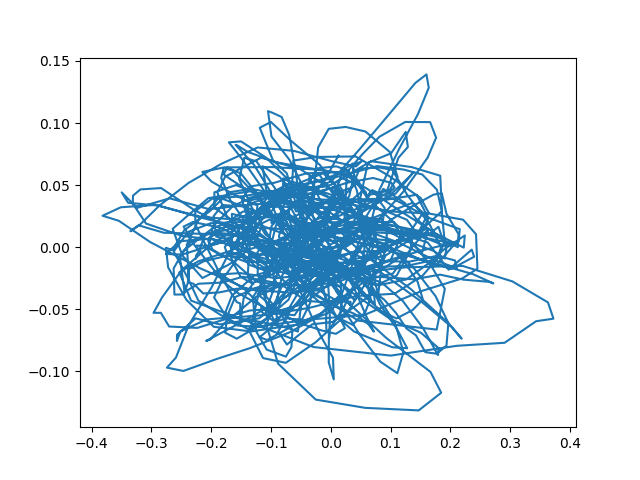

In [78]:
plt.figure()
plt.plot(U,V)

In [79]:
print(SD_U,SD_V) # this is what you want to use in master sheet " SD_U " 

0.120149523161 0.0403250218817


In [80]:
# start putting all output into one sheet 
out = [Mean_VU,Max_VU,Min_VU,SD_VU,Mean_VN,Max_VN,Min_VN,SD_VN,Max_VE,
       Min_VE,Mean_VE,SD_VE,SD_U,Mean_Depth,Max_Depth,Min_Depth,SD_Depth,Month,Day,Year,Start_Time]
header = 'Mean VU(m/s), Max VU(m/s), Min VU(m/s), SD VU(m/s), Mean VN(m/s), Max VN(m/s), Min VN(m/s), SD VN(m/s), Mean VE(m/s), Max VE(m/s), Min VE(m/s), SD VE(m/s), SD_U(m/s), Mean Depth(m), Max Depth(m), Min Depth(m), SD Depth(m), Month, Day, Year, Start Time'
#output= pd.DataFrame[Mean_VN, Mean_VE, Mean_VU]

out2=np.array([out])


In [81]:
# save all veriables in new output .csv. Only use this for the first time stamp or it will override next time stamp
np.savetxt("ADV_out_PCA.csv", out2, delimiter=",", fmt='%s', header=header)

In [82]:
# after first time stamp use this cell on runs i+1 ....i+inf to add to the same sheet as in cell 81
with open("ADV_out_PCA.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(out)